# Classification models to predict the property prices in Montreal, Canada.

We categorize our entire dataset into two levels. The first level assigned with a value of 0 will indicate a property price less 0.5 million dollars, while the second level assigned with a value of 1 will indicate a property price greater than 1.0 million dollars.

Load the required Python packages.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Start the clock for estimating the code execution time.

In [2]:
t00 = time.time()

Load the dataset.

In [3]:
%pip install openpyxl
# path = "../input/montrealproperties/clean_Montreal_property_listings.xlsx"
path ="./clean_Montreal_property_listings.xlsx"
data = pd.read_excel(path)
data.drop(columns= 'address', inplace= True)
print(data.shape)
data.head()


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
(813, 3)


,price,region,bedrooms
0,849000.0,Mercier / Hochelaga / Maisonneuve,3
1,420000.0,Villeray / St-Michel / Parc-Extension,2
2,699000.0,Pointe-Aux-Trembles / Montréal-Est,3
3,349000.0,Rosemont / La Petite Patrie,1
4,959000.0,Ahuntsic / Cartierville,4


Check NaN values.

In [4]:
data.isna().sum()

price       2
region      0
bedrooms    0
dtype: int64

Drop the NaN values.

In [5]:
data.dropna(inplace= True)

In [6]:
data.isna().sum()

price       0
region      0
bedrooms    0
dtype: int64

Check the range of listing prices in different regions.

In [7]:
data_describe = data.groupby('region')['price'].describe().reset_index()[['region','count', 'mean', 'min', 'max']].round(3)
data_describe.sort_values(by= 'count', ascending= False, inplace= True)
data_describe.rename(columns= 
    {'count' : 'no_of_listings',
    'mean': 'mean_price',
    'min' : 'min_price',
    'max' : 'max_price'}).reset_index().drop(columns= ['index'])

,region,no_of_listings,mean_price,min_price,max_price
0,Ville-Marie (Centre-Ville et Vieux Mtl),143.0,622306.566,264900.0,2650000.0
1,Mercier / Hochelaga / Maisonneuve,87.0,616634.368,209000.0,2400000.0
2,Rosemont / La Petite Patrie,62.0,694286.452,265000.0,2750000.0
3,Ahuntsic / Cartierville,62.0,625556.435,239000.0,1569000.0
4,Villeray / St-Michel / Parc-Extension,53.0,701269.698,269000.0,2450000.0
5,Le Plateau-Mont-Royal,50.0,867939.400,275000.0,2995000.0
6,Le Sud-Ouest,46.0,677583.652,229500.0,1650000.0
7,Côte-des-Neiges / Notre-Dame-de-Grâce,41.0,646209.756,265000.0,2850000.0
8,Saint-Laurent,39.0,689064.436,295000.0,1750000.0
9,Griffintown,29.0,495055.172,259000.0,810000.0


The exploratory data analysis showed that both, the region where the property is located, as well as the number of bedrooms a property has are important factors in deciding the listing price of the property.

Therefore, we would like to predict the price of a house using the two features, named **region** and **bedrooms**.

Add a new column into the dataframe named **pricem** showing house price in the units of Million dollars.

In [8]:
data['pricem'] = data['price']/1e6

The exploratory data analysis also showed that majority of the house prices in the dataset were between 0.2-1.4 Million dollars.

For our machine learning model building, we keep the houses with price less than 1.0 Million dollars.

In [9]:
data = data.loc[data.pricem < 1.0]

In [10]:
print('The maximum price a house has in the dataframe is', max(data.pricem), 'Million dollars, while the minimum price is', min(data.pricem), 'Million dollars.')

The maximum price a house has in the dataframe is 0.99955 Million dollars, while the minimum price is 0.209 Million dollars.


/var/folders/m9/9vx0zm4904qdn2jzwc0shtpm0000gn/T/ipykernel_4321/576979791.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.pricem, color= 'green')


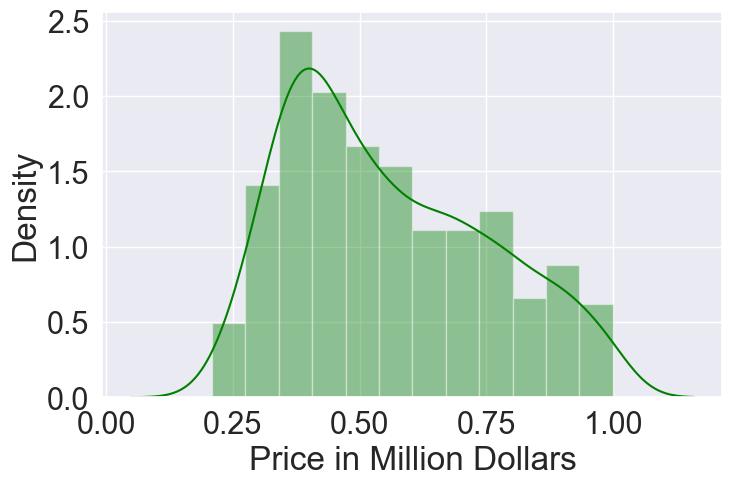

In [11]:
sns.set(font_scale=2)
plt.figure(figsize=(8,5))
sns.distplot(data.pricem, color= 'green')
plt.xlabel('Price in Million Dollars')
plt.ylabel('Density');

Assign a label 0 to the properties with listing price less than 0.5 million dollars, and a label 1 to the properties with listing price more than 0.5 million dollars.

In [12]:
data['label'] = 0
data.loc[data.pricem < 0.5, 'label'] = 0
data.loc[data.pricem > 0.5, 'label'] = 1
data.head()

,price,region,bedrooms,pricem,label
0,849000.0,Mercier / Hochelaga / Maisonneuve,3,0.849,1
1,420000.0,Villeray / St-Michel / Parc-Extension,2,0.420,0
2,699000.0,Pointe-Aux-Trembles / Montréal-Est,3,0.699,1
3,349000.0,Rosemont / La Petite Patrie,1,0.349,0
4,959000.0,Ahuntsic / Cartierville,4,0.959,1


In [13]:
data['label'] = data['label'].apply(lambda x : int(x))

In [14]:
data.dtypes

price       float64
region       object
bedrooms      int64
pricem      float64
label         int64
dtype: object

In [15]:
print(data.shape)

(711, 5)


In [16]:
Y = data.label
print(len(Y))
Y

711


0      1
1      0
2      1
3      0
4      1
      ..
808    0
809    1
810    0
811    0
812    0
Name: label, Length: 711, dtype: int64

In [40]:
Y.unique()

,bedrooms,region_Ahuntsic / Cartierville,region_Anjou,region_Beaconsfield / Baie-D'Urfé,region_Côte-St-Luc / Hampstead / Montréal-Ouest,region_Côte-des-Neiges / Notre-Dame-de-Grâce,region_Dollard-Des-Ormeaux,region_Dorval / L'Île Dorval,region_Griffintown,region_Kirkland,...,region_Pointe-Claire,region_Rivière des Prairies,region_Rosemont / La Petite Patrie,region_Saint-Laurent,region_Saint-Léonard,region_Ste-Anne-De-Bellevue,region_Verdun,region_Ville-Marie (Centre-Ville et Vieux Mtl),region_Villeray / St-Michel / Parc-Extension,region_Westmount
0,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,4,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
809,2,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
810,1,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
811,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Get dummy variables for the **region** column.

In [39]:
X = pd.get_dummies(data.drop(columns= ["price", "pricem", "label"]), prefix= 'region')
print(X.shape)
X

(711, 32)


,bedrooms,region_Ahuntsic / Cartierville,region_Anjou,region_Beaconsfield / Baie-D'Urfé,region_Côte-St-Luc / Hampstead / Montréal-Ouest,region_Côte-des-Neiges / Notre-Dame-de-Grâce,region_Dollard-Des-Ormeaux,region_Dorval / L'Île Dorval,region_Griffintown,region_Kirkland,...,region_Pointe-Claire,region_Rivière des Prairies,region_Rosemont / La Petite Patrie,region_Saint-Laurent,region_Saint-Léonard,region_Ste-Anne-De-Bellevue,region_Verdun,region_Ville-Marie (Centre-Ville et Vieux Mtl),region_Villeray / St-Michel / Parc-Extension,region_Westmount
0,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,4,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
809,2,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
810,1,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
811,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Split data into training and testing datasets.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, train_size= 0.7, random_state= 1)

Training dataset contains 70% of the total data.

In [20]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(497, 32)
(214, 32)
(497,)
(214,)


## K-Nearest Neighbors Model

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [22]:
accuracy_score(Y_test, knn.predict(X_test))

0.7149532710280374

GridSearchCV for hyperparameter tuning.

In [23]:
t0 = time.time()
parameters = {
    'n_neighbors' : range(1,15),
    'weights' : ('uniform', 'distance'),
    'algorithm' : ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'p' : range(1,4)
}
gs_knn = GridSearchCV(
    estimator= knn,
    param_grid= parameters,
    cv = 5,
    return_train_score= True
    )
gs_knn.fit(X_train, Y_train)
time_knn = time.time()-t0
print('Hyperparameter tuning for the K-Nearest Neighbors model took', time_knn, 'seconds.')

Hyperparameter tuning for the K-Nearest Neighbors model took 38.96908402442932 seconds.


Best score obtained for the hyperparameter tuning cross-validation.

In [24]:
gs_knn.best_score_

0.7886666666666666

Best parameter values after the hyperparameter tuning.

In [25]:
gs_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}

In [26]:
gs_results  = pd.DataFrame(gs_knn.cv_results_)
gs_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_algorithm', 'param_n_neighbors', 'param_p', 'param_weights',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [27]:
gs_results = gs_results[['mean_test_score', 'mean_train_score', 'params']]
gs_results

,mean_test_score,mean_train_score,params
0,0.734525,0.784699,"{'algorithm': 'auto', 'n_neighbors': 1, 'p': 1..."
1,0.734525,0.784699,"{'algorithm': 'auto', 'n_neighbors': 1, 'p': 1..."
2,0.734525,0.784699,"{'algorithm': 'auto', 'n_neighbors': 1, 'p': 2..."
3,0.734525,0.784699,"{'algorithm': 'auto', 'n_neighbors': 1, 'p': 2..."
4,0.734525,0.784699,"{'algorithm': 'auto', 'n_neighbors': 1, 'p': 3..."
...,...,...,...
331,0.788646,0.828967,"{'algorithm': 'brute', 'n_neighbors': 14, 'p':..."
332,0.766586,0.782178,"{'algorithm': 'brute', 'n_neighbors': 14, 'p':..."
333,0.788646,0.828967,"{'algorithm': 'brute', 'n_neighbors': 14, 'p':..."
334,0.766586,0.782178,"{'algorithm': 'brute', 'n_neighbors': 14, 'p':..."


Mean value for testing and training score after hyperparameter cross validation.

In [28]:
gs_results.loc[gs_results.params == gs_knn.best_params_]

,mean_test_score,mean_train_score,params
43,0.788667,0.827458,"{'algorithm': 'auto', 'n_neighbors': 8, 'p': 1..."


K-Nearest Neighbors model accuracy with optimized parameters.

In [29]:
knn_optimized = KNeighborsClassifier(
    n_neighbors= gs_knn.best_params_['n_neighbors'],
    algorithm= gs_knn.best_params_['algorithm'],
    p= gs_knn.best_params_['p'],
    weights= gs_knn.best_params_['weights'])

knn_optimized.fit(X_train, Y_train)
yhat_optimized = knn_optimized.predict(X_test)
accuracy_score(yhat_optimized, Y_test)

0.822429906542056

Confusion Matrix for optimized K-Nearest Neighbors model.

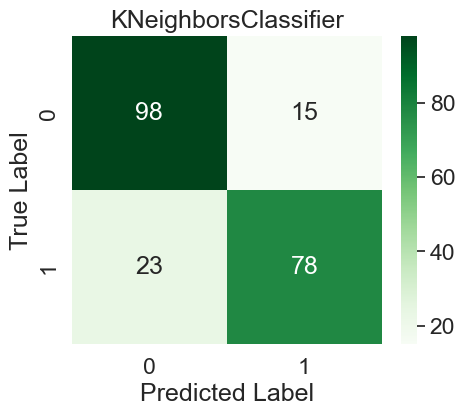

In [30]:
sns.set(font_scale= 1.5)
plt.figure(figsize= (5,4))
h =sns.heatmap(confusion_matrix(y_true= Y_test, y_pred= yhat_optimized), annot= True, cmap= 'Greens', fmt = 'g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KNeighborsClassifier');

# Random Forest Model

In [31]:
rf = RandomForestClassifier(random_state= 34)
rf.fit(X_train, Y_train)
accuracy_score(rf.predict(X_test), Y_test)

0.8037383177570093

Optimizing number of trees values in the forest.

In [32]:
train_accuracy = []
n_trees = np.arange(1, 103, 5)
for tree in n_trees:
    rf = RandomForestClassifier(n_estimators= tree, random_state= 34)
    rf.fit(X_train, Y_train)
    train_accuracy_iter = accuracy_score(rf.predict(X_train), Y_train)
    train_accuracy.append(train_accuracy_iter)

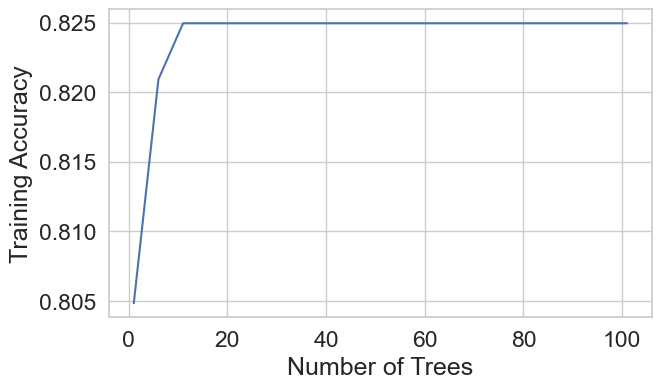

In [33]:
sns.set(font_scale= 1.5)
sns.set_style('whitegrid')
plt.figure(figsize= (7, 4))
sns.lineplot(x = n_trees, y =train_accuracy)
plt.xlabel('Number of Trees')
plt.ylabel('Training Accuracy');

In [34]:
print(max(train_accuracy))
array = n_trees[train_accuracy == max(train_accuracy)]
array

0.8249496981891348


array([ 11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,  66,  71,
        76,  81,  86,  91,  96, 101])

Random forest model with optimized number of trees.

In [35]:
rf_optimized = RandomForestClassifier(
    n_estimators = array[0],
    random_state= 34
)
rf_optimized.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=11, random_state=34)

Accuracy for the optimized Random forest model.

In [ ]:
X_test

In [36]:
yhat_optimized = rf_optimized.predict(X_test)
accuracy_score(yhat_optimized, Y_test)

0.7990654205607477

Confusion matrix for the optimized Random forest model.

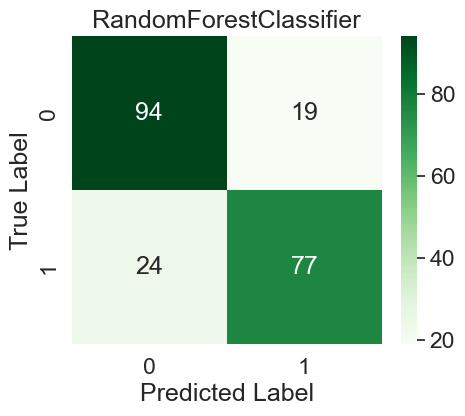

In [37]:
sns.set(font_scale=1.5)
plt.figure(figsize= (5,4))
sns.heatmap(confusion_matrix(y_true= Y_test, y_pred= yhat_optimized), annot= True, cmap= 'Greens', fmt = 'g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RandomForestClassifier');

In [41]:
print('Execution of entire code in the notebook (excluding time to load the packages) took', time.time()-t00, 'seconds.')
import pickle

# Save the trained model to a file
with open('model.pkl', 'wb') as model_file:
    pickle.dump(rf_optimized, model_file)
# Model usage:

Execution of entire code in the notebook (excluding time to load the packages) took 1313.1681139469147 seconds.


Author:

Mangaljit Singh